In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-06 14:57:11,801] A new study created in memory with name: no-name-282a8221-79b6-4ee3-aeac-fcac6f96923c
[I 2025-06-06 14:58:50,237] Trial 0 finished with value: 0.15780440270900725 and parameters: {'lr': 0.42711320857176227, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3673561871418556}. Best is trial 0 with value: 0.15780440270900725.


Cross Validation Accuracies:
[0.10048992931842804, 0.195195734500885, 0.1545753926038742, 0.09271663427352905, 0.24604432284832]
Mean Cross Validation Accuracy:
0.15780440270900725
Standard Deviation of Cross Validation Accuracy:
0.05782073705094303


[I 2025-06-06 15:00:55,995] Trial 1 finished with value: 3.1447216749191282 and parameters: {'lr': 0.04031703787866087, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4746713062301058}. Best is trial 0 with value: 0.15780440270900725.


Cross Validation Accuracies:
[3.1705048084259033, 4.06301212310791, 1.0491324663162231, 3.568470001220703, 3.8724889755249023]
Mean Cross Validation Accuracy:
3.1447216749191282
Standard Deviation of Cross Validation Accuracy:
1.0903782954824013


[I 2025-06-06 15:02:36,226] Trial 2 finished with value: 0.09333998821675778 and parameters: {'lr': 0.05866235131001076, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.27994005635542574}. Best is trial 2 with value: 0.09333998821675778.


Cross Validation Accuracies:
[0.032266344875097275, 0.1814597100019455, 0.12686468660831451, 0.10477866232395172, 0.021330537274479866]
Mean Cross Validation Accuracy:
0.09333998821675778
Standard Deviation of Cross Validation Accuracy:
0.05989187753127631


[I 2025-06-06 15:04:00,795] Trial 3 finished with value: 0.24467723965644836 and parameters: {'lr': 0.4877143312710495, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3290671525913169}. Best is trial 2 with value: 0.09333998821675778.


Cross Validation Accuracies:
[0.16670656204223633, 0.27481645345687866, 0.2445133477449417, 0.20478592813014984, 0.3325639069080353]
Mean Cross Validation Accuracy:
0.24467723965644836
Standard Deviation of Cross Validation Accuracy:
0.0571020291278085


[I 2025-06-06 15:05:57,626] Trial 4 finished with value: 0.17417705059051514 and parameters: {'lr': 0.04661321904505336, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.36996995398038646}. Best is trial 2 with value: 0.09333998821675778.


Cross Validation Accuracies:
[0.12891732156276703, 0.26626887917518616, 0.317022442817688, 0.076054647564888, 0.08262196183204651]
Mean Cross Validation Accuracy:
0.17417705059051514
Standard Deviation of Cross Validation Accuracy:
0.09893886425198456


[I 2025-06-06 15:07:37,169] Trial 5 finished with value: 11.407089138031006 and parameters: {'lr': 0.600514876490663, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17592980478678402}. Best is trial 2 with value: 0.09333998821675778.


Cross Validation Accuracies:
[2.3748724460601807, 25.431964874267578, 23.746599197387695, 3.130697011947632, 2.3513121604919434]
Mean Cross Validation Accuracy:
11.407089138031006
Standard Deviation of Cross Validation Accuracy:
10.780049624970935


[I 2025-06-06 15:09:48,284] Trial 6 finished with value: 0.0986528754234314 and parameters: {'lr': 0.5071747892941479, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28902821885921925}. Best is trial 2 with value: 0.09333998821675778.


Cross Validation Accuracies:
[0.07801660150289536, 0.12983009219169617, 0.07340382784605026, 0.1271820217370987, 0.0848318338394165]
Mean Cross Validation Accuracy:
0.0986528754234314
Standard Deviation of Cross Validation Accuracy:
0.024658963604163607


[I 2025-06-06 15:11:28,929] Trial 7 finished with value: 0.18280773162841796 and parameters: {'lr': 0.387036136523336, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4472302946498026}. Best is trial 2 with value: 0.09333998821675778.


Cross Validation Accuracies:
[0.07461781799793243, 0.1848696917295456, 0.13640901446342468, 0.27307775616645813, 0.245064377784729]
Mean Cross Validation Accuracy:
0.18280773162841796
Standard Deviation of Cross Validation Accuracy:
0.07195375927096248


[I 2025-06-06 15:13:00,688] Trial 8 finished with value: 0.0770146070048213 and parameters: {'lr': 0.0022955014151474972, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.19546887429963486}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.11396948248147964, 0.12356513738632202, 0.0683193951845169, 0.07599253207445145, 0.003226487897336483]
Mean Cross Validation Accuracy:
0.0770146070048213
Standard Deviation of Cross Validation Accuracy:
0.042553384277817345


[I 2025-06-06 15:14:28,129] Trial 9 finished with value: 0.10626475661993026 and parameters: {'lr': 0.2814420431758104, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23752207955380916}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.13242976367473602, 0.13386456668376923, 0.05334717407822609, 0.15992052853107452, 0.051761750131845474]
Mean Cross Validation Accuracy:
0.10626475661993026
Standard Deviation of Cross Validation Accuracy:
0.044935836984342566


[I 2025-06-06 15:16:44,603] Trial 10 finished with value: 0.10339921563863755 and parameters: {'lr': 0.0011118788670571133, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12220225307454476}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.13138769567012787, 0.12115832418203354, 0.07216430455446243, 0.10168996453285217, 0.0905957892537117]
Mean Cross Validation Accuracy:
0.10339921563863755
Standard Deviation of Cross Validation Accuracy:
0.02117172589895506


[I 2025-06-06 15:18:18,966] Trial 11 finished with value: 0.10589095652103424 and parameters: {'lr': 0.002326045906260859, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.22642098572073013}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.10783493518829346, 0.15036894381046295, 0.06332267820835114, 0.13559077680110931, 0.07233744859695435]
Mean Cross Validation Accuracy:
0.10589095652103424
Standard Deviation of Cross Validation Accuracy:
0.03406477929933919


[I 2025-06-06 15:19:49,900] Trial 12 finished with value: 0.1009495086967945 and parameters: {'lr': 0.00788254054688809, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.11081910680928492}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.10890352725982666, 0.13014449179172516, 0.07557490468025208, 0.13714411854743958, 0.05298050120472908]
Mean Cross Validation Accuracy:
0.1009495086967945
Standard Deviation of Cross Validation Accuracy:
0.03215761011090507


[I 2025-06-06 15:21:07,254] Trial 13 finished with value: 0.12327266409993172 and parameters: {'lr': 0.010850868013168653, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2374362690931907}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.053611792623996735, 0.18814589083194733, 0.11515053361654282, 0.22359347343444824, 0.035861629992723465]
Mean Cross Validation Accuracy:
0.12327266409993172
Standard Deviation of Cross Validation Accuracy:
0.07325584650281966


[I 2025-06-06 15:22:40,226] Trial 14 finished with value: 0.9966958284378051 and parameters: {'lr': 0.014771872963077961, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1625231462404746}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.9675734639167786, 0.9181607365608215, 1.1818934679031372, 1.0272963047027588, 0.8885551691055298]
Mean Cross Validation Accuracy:
0.9966958284378051
Standard Deviation of Cross Validation Accuracy:
0.10386994732203743


[I 2025-06-06 15:24:12,407] Trial 15 finished with value: 1.5448275923728942 and parameters: {'lr': 0.13078814238735115, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.28494401976598926}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[2.37906813621521, 0.9166814088821411, 1.2495007514953613, 0.9718206524848938, 2.2070670127868652]
Mean Cross Validation Accuracy:
1.5448275923728942
Standard Deviation of Cross Validation Accuracy:
0.6236410600460922


[I 2025-06-06 15:25:41,733] Trial 16 finished with value: 0.23838532119989395 and parameters: {'lr': 0.10204293578837076, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20820414025822592}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.11459875851869583, 0.259577214717865, 0.24239316582679749, 0.3106482923030853, 0.2647091746330261]
Mean Cross Validation Accuracy:
0.23838532119989395
Standard Deviation of Cross Validation Accuracy:
0.06588346457509094


[I 2025-06-06 15:27:51,472] Trial 17 finished with value: 0.09829288497567176 and parameters: {'lr': 0.004201178731164833, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.332184078758373}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.10040872544050217, 0.1291259527206421, 0.08448506891727448, 0.12647221982479095, 0.050972457975149155]
Mean Cross Validation Accuracy:
0.09829288497567176
Standard Deviation of Cross Validation Accuracy:
0.028910580609152938


[I 2025-06-06 15:29:13,750] Trial 18 finished with value: 0.10796355530619621 and parameters: {'lr': 0.021318583303462726, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1618303075516272}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.04353034868836403, 0.12364155054092407, 0.1438574343919754, 0.1126592606306076, 0.11612918227910995]
Mean Cross Validation Accuracy:
0.10796355530619621
Standard Deviation of Cross Validation Accuracy:
0.03398392360459698


[I 2025-06-06 15:30:49,734] Trial 19 finished with value: 3.17120943069458 and parameters: {'lr': 0.06973758699821028, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4064131995189652}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[3.2986338138580322, 2.875210762023926, 3.1513702869415283, 3.3569071292877197, 3.1739251613616943]
Mean Cross Validation Accuracy:
3.17120943069458
Standard Deviation of Cross Validation Accuracy:
0.16657538075002867


[I 2025-06-06 15:33:26,783] Trial 20 finished with value: 0.08124598897993565 and parameters: {'lr': 0.0053936724019220394, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2593559969071576}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.08611518889665604, 0.1330914944410324, 0.05238286405801773, 0.11190463602542877, 0.02273576147854328]
Mean Cross Validation Accuracy:
0.08124598897993565
Standard Deviation of Cross Validation Accuracy:
0.03976969923328227


[I 2025-06-06 15:35:53,353] Trial 21 finished with value: 0.1041887380182743 and parameters: {'lr': 0.00410699337507938, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.26499342238822593}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.13608454167842865, 0.12212871015071869, 0.09740149974822998, 0.1278688907623291, 0.037460047751665115]
Mean Cross Validation Accuracy:
0.1041887380182743
Standard Deviation of Cross Validation Accuracy:
0.03577350760899239


[I 2025-06-06 15:38:27,672] Trial 22 finished with value: 0.0972082868218422 and parameters: {'lr': 0.0010497081878994643, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.20119343587902372}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.10361514985561371, 0.12877941131591797, 0.0711773931980133, 0.12665314972400665, 0.05581633001565933]
Mean Cross Validation Accuracy:
0.0972082868218422
Standard Deviation of Cross Validation Accuracy:
0.02931103975699669


[I 2025-06-06 15:40:56,196] Trial 23 finished with value: 0.0992616631090641 and parameters: {'lr': 0.004986179202932795, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.26304057720092644}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.14545938372612, 0.12925180792808533, 0.05807430297136307, 0.13848777115345, 0.02503504976630211]
Mean Cross Validation Accuracy:
0.0992616631090641
Standard Deviation of Cross Validation Accuracy:
0.04853517176694821


[I 2025-06-06 15:43:23,668] Trial 24 finished with value: 0.09302504286170006 and parameters: {'lr': 0.0022745736633739805, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3139930959923135}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.1252220869064331, 0.12414813041687012, 0.07019291073083878, 0.11111569404602051, 0.034446392208337784]
Mean Cross Validation Accuracy:
0.09302504286170006
Standard Deviation of Cross Validation Accuracy:
0.035455133491407935


[I 2025-06-06 15:45:42,549] Trial 25 finished with value: 0.21027884632349014 and parameters: {'lr': 0.0021263735287126427, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3239014383894704}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.2988590896129608, 0.12710100412368774, 0.05289382487535477, 0.35337698459625244, 0.21916332840919495]
Mean Cross Validation Accuracy:
0.21027884632349014
Standard Deviation of Cross Validation Accuracy:
0.10962761432187501


[I 2025-06-06 15:47:48,163] Trial 26 finished with value: 0.10584110170602798 and parameters: {'lr': 0.0023992146585018843, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.36289003493754024}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.12537623941898346, 0.12161122262477875, 0.07398564368486404, 0.139562726020813, 0.06866967678070068]
Mean Cross Validation Accuracy:
0.10584110170602798
Standard Deviation of Cross Validation Accuracy:
0.02885810562875199


[I 2025-06-06 15:49:42,063] Trial 27 finished with value: 0.10889969766139984 and parameters: {'lr': 0.0063593239394409695, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3097775407506214}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.18135584890842438, 0.12167524546384811, 0.06557611376047134, 0.10287198424339294, 0.07301929593086243]
Mean Cross Validation Accuracy:
0.10889969766139984
Standard Deviation of Cross Validation Accuracy:
0.04150609100987348


[I 2025-06-06 15:52:32,754] Trial 28 finished with value: 0.1457847997546196 and parameters: {'lr': 0.0021884448229757838, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14808852063993863}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.06693001091480255, 0.18281155824661255, 0.2170369029045105, 0.22981968522071838, 0.03232584148645401]
Mean Cross Validation Accuracy:
0.1457847997546196
Standard Deviation of Cross Validation Accuracy:
0.08074740609738108


[I 2025-06-06 15:55:13,192] Trial 29 finished with value: 0.09994742870330811 and parameters: {'lr': 0.020012390761359432, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19810996308851533}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.10444240272045135, 0.12884460389614105, 0.08397282660007477, 0.13286952674388885, 0.0496077835559845]
Mean Cross Validation Accuracy:
0.09994742870330811
Standard Deviation of Cross Validation Accuracy:
0.030751857995408253


[I 2025-06-06 15:57:24,015] Trial 30 finished with value: 0.10135776922106743 and parameters: {'lr': 0.003157125075266024, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3605925333911782}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.11515763401985168, 0.1353936493396759, 0.0872071385383606, 0.1435249149799347, 0.025505509227514267]
Mean Cross Validation Accuracy:
0.10135776922106743
Standard Deviation of Cross Validation Accuracy:
0.04261631443522661


[I 2025-06-06 15:58:45,568] Trial 31 finished with value: 0.09882287606596947 and parameters: {'lr': 0.0015776264138720934, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2577151715899661}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.11264051496982574, 0.1246294379234314, 0.08249559253454208, 0.13197840750217438, 0.042370427399873734]
Mean Cross Validation Accuracy:
0.09882287606596947
Standard Deviation of Cross Validation Accuracy:
0.03289271710428111


[I 2025-06-06 16:00:09,619] Trial 32 finished with value: 0.11543609835207462 and parameters: {'lr': 0.029102863965874203, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.28888048738452426}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.11736446619033813, 0.12467066198587418, 0.10243449360132217, 0.20713374018669128, 0.025577129796147346]
Mean Cross Validation Accuracy:
0.11543609835207462
Standard Deviation of Cross Validation Accuracy:
0.057863856148870504


[I 2025-06-06 16:02:08,622] Trial 33 finished with value: 0.157243512570858 and parameters: {'lr': 0.00969908656516971, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.40606342789962047}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.16682806611061096, 0.12605799734592438, 0.09372232109308243, 0.1957569420337677, 0.20385223627090454]
Mean Cross Validation Accuracy:
0.157243512570858
Standard Deviation of Cross Validation Accuracy:
0.04184494991536968


[I 2025-06-06 16:03:29,304] Trial 34 finished with value: 0.10646260790526867 and parameters: {'lr': 0.14702159092164688, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3441723500607984}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.11111018806695938, 0.15213482081890106, 0.05977489426732063, 0.1790650337934494, 0.030228102579712868]
Mean Cross Validation Accuracy:
0.10646260790526867
Standard Deviation of Cross Validation Accuracy:
0.05544385572019234


[I 2025-06-06 16:04:59,424] Trial 35 finished with value: 0.09637982845306396 and parameters: {'lr': 0.0419550502085958, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3114511027694509}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.07985454797744751, 0.15314185619354248, 0.06251705437898636, 0.064980648458004, 0.12140503525733948]
Mean Cross Validation Accuracy:
0.09637982845306396
Standard Deviation of Cross Validation Accuracy:
0.0353662823490386


[I 2025-06-06 16:06:31,346] Trial 36 finished with value: 0.35489205121994016 and parameters: {'lr': 0.006433392096204738, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.49973545708973827}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.39554229378700256, 0.3831697106361389, 0.3506370782852173, 0.28433045744895935, 0.3607807159423828]
Mean Cross Validation Accuracy:
0.35489205121994016
Standard Deviation of Cross Validation Accuracy:
0.03868795141955446


[I 2025-06-06 16:08:43,050] Trial 37 finished with value: 0.09793851673603057 and parameters: {'lr': 0.0014680018533709098, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3927612467064927}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.10996782779693604, 0.13047631084918976, 0.07398996502161026, 0.12383665144443512, 0.05142182856798172]
Mean Cross Validation Accuracy:
0.09793851673603057
Standard Deviation of Cross Validation Accuracy:
0.03036926459125011


[I 2025-06-06 16:10:10,790] Trial 38 finished with value: 0.6659960448741913 and parameters: {'lr': 0.05643612485944473, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.24871380381591912}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.41373804211616516, 1.4448316097259521, 1.0193722248077393, 0.10451120138168335, 0.3475271463394165]
Mean Cross Validation Accuracy:
0.6659960448741913
Standard Deviation of Cross Validation Accuracy:
0.4922969287703542


[I 2025-06-06 16:11:38,857] Trial 39 finished with value: 0.10122343823313713 and parameters: {'lr': 0.0028791556618833415, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21910364595040208}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.13303248584270477, 0.13608968257904053, 0.07972311228513718, 0.10880496352910995, 0.04846694692969322]
Mean Cross Validation Accuracy:
0.10122343823313713
Standard Deviation of Cross Validation Accuracy:
0.03325796572537187


[I 2025-06-06 16:13:10,507] Trial 40 finished with value: 2.093866229057312 and parameters: {'lr': 0.21032655712966497, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1815342217772682}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[3.536018133163452, 0.9484450817108154, 3.542613983154297, 1.7144449949264526, 0.727808952331543]
Mean Cross Validation Accuracy:
2.093866229057312
Standard Deviation of Cross Validation Accuracy:
1.2248048604174786


[I 2025-06-06 16:14:25,173] Trial 41 finished with value: 0.10826526414602995 and parameters: {'lr': 0.032796951927960886, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2995009293927852}. Best is trial 8 with value: 0.0770146070048213.


Cross Validation Accuracies:
[0.13669542968273163, 0.170785591006279, 0.1457889974117279, 0.07891029864549637, 0.009146003983914852]
Mean Cross Validation Accuracy:
0.10826526414602995
Standard Deviation of Cross Validation Accuracy:
0.05798523583805529


[I 2025-06-06 16:15:51,421] Trial 42 finished with value: 0.06893745474517346 and parameters: {'lr': 0.06318439670364742, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30801763552048006}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.028075238689780235, 0.1664738804101944, 0.05312419682741165, 0.06679631769657135, 0.030217640101909637]
Mean Cross Validation Accuracy:
0.06893745474517346
Standard Deviation of Cross Validation Accuracy:
0.05086637921517326


[I 2025-06-06 16:17:12,080] Trial 43 finished with value: 0.08486214131116868 and parameters: {'lr': 0.09864713084308485, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2766150454745955}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.04631740599870682, 0.123556949198246, 0.05383053421974182, 0.10125778615474701, 0.0993480309844017]
Mean Cross Validation Accuracy:
0.08486214131116868
Standard Deviation of Cross Validation Accuracy:
0.029747616999901336


[I 2025-06-06 16:18:26,189] Trial 44 finished with value: 0.08650731295347214 and parameters: {'lr': 0.08887521481001952, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2728411735610695}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.1374519169330597, 0.12621374428272247, 0.06870999187231064, 0.08843747526407242, 0.011723436415195465]
Mean Cross Validation Accuracy:
0.08650731295347214
Standard Deviation of Cross Validation Accuracy:
0.04491113830186206


[I 2025-06-06 16:19:51,301] Trial 45 finished with value: 28.68033790588379 and parameters: {'lr': 0.7907259833950895, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.24418308323523313}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[57.99736785888672, 11.345842361450195, 5.987691879272461, 37.70620346069336, 30.36458396911621]
Mean Cross Validation Accuracy:
28.68033790588379
Standard Deviation of Cross Validation Accuracy:
18.757569664268075


[I 2025-06-06 16:21:16,951] Trial 46 finished with value: 0.1252162627875805 and parameters: {'lr': 0.07059876404866741, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.270834878064158}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.14965222775936127, 0.15224170684814453, 0.055928703397512436, 0.174123153090477, 0.09413552284240723]
Mean Cross Validation Accuracy:
0.1252162627875805
Standard Deviation of Cross Validation Accuracy:
0.04355721114039332


[I 2025-06-06 16:22:54,158] Trial 47 finished with value: 27.439320373535157 and parameters: {'lr': 0.25050990512408267, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.22703848232896473}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[27.8190975189209, 30.01386070251465, 30.041210174560547, 19.727699279785156, 29.59473419189453]
Mean Cross Validation Accuracy:
27.439320373535157
Standard Deviation of Cross Validation Accuracy:
3.9409955022639545


[I 2025-06-06 16:24:18,299] Trial 48 finished with value: 0.09724471755325795 and parameters: {'lr': 0.09179425171178604, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.34586911985775987}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.14717356860637665, 0.12956400215625763, 0.07221454381942749, 0.1180787906050682, 0.019192682579159737]
Mean Cross Validation Accuracy:
0.09724471755325795
Standard Deviation of Cross Validation Accuracy:
0.04623876011617517


[I 2025-06-06 16:25:40,195] Trial 49 finished with value: 0.2076597735285759 and parameters: {'lr': 0.17451484022081962, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27945771932510066}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.24450410902500153, 0.22523848712444305, 0.11269719153642654, 0.255607932806015, 0.20025114715099335]
Mean Cross Validation Accuracy:
0.2076597735285759
Standard Deviation of Cross Validation Accuracy:
0.05106529532152275


[I 2025-06-06 16:27:05,659] Trial 50 finished with value: 2.6937546014785765 and parameters: {'lr': 0.32043838048519924, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.14079093389811584}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[4.286731243133545, 1.9211745262145996, 2.4327590465545654, 2.8462884426116943, 1.981819748878479]
Mean Cross Validation Accuracy:
2.6937546014785765
Standard Deviation of Cross Validation Accuracy:
0.8640244256131735


[I 2025-06-06 16:28:33,533] Trial 51 finished with value: 0.1035142682492733 and parameters: {'lr': 0.08979388483864775, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3027804838624526}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.06356991082429886, 0.12155424803495407, 0.11341839283704758, 0.2032098025083542, 0.015818987041711807]
Mean Cross Validation Accuracy:
0.1035142682492733
Standard Deviation of Cross Validation Accuracy:
0.06268771194084036


[I 2025-06-06 16:30:01,933] Trial 52 finished with value: 0.10859207957983016 and parameters: {'lr': 0.11870418102124053, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3240931456429003}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.03613241761922836, 0.16767816245555878, 0.05272263288497925, 0.16666610538959503, 0.11976107954978943]
Mean Cross Validation Accuracy:
0.10859207957983016
Standard Deviation of Cross Validation Accuracy:
0.05542617054986412


[I 2025-06-06 16:31:17,674] Trial 53 finished with value: 0.10466891825199127 and parameters: {'lr': 0.001549636994880814, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.286099764420789}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.09174217283725739, 0.13099586963653564, 0.09233967214822769, 0.13681384921073914, 0.0714530274271965]
Mean Cross Validation Accuracy:
0.10466891825199127
Standard Deviation of Cross Validation Accuracy:
0.025095064914584412


[I 2025-06-06 16:33:29,912] Trial 54 finished with value: 0.09229037649929524 and parameters: {'lr': 0.04990494522926605, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.18529610011061223}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.0309381652623415, 0.18995605409145355, 0.14380234479904175, 0.0753718912601471, 0.02138342708349228]
Mean Cross Validation Accuracy:
0.09229037649929524
Standard Deviation of Cross Validation Accuracy:
0.06522298965787418


[I 2025-06-06 16:34:45,482] Trial 55 finished with value: 0.15291410386562349 and parameters: {'lr': 0.05357991450828073, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19469660255886345}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.15290658175945282, 0.12655317783355713, 0.15671661496162415, 0.19816578924655914, 0.13022835552692413]
Mean Cross Validation Accuracy:
0.15291410386562349
Standard Deviation of Cross Validation Accuracy:
0.02558013204026652


[I 2025-06-06 16:36:15,184] Trial 56 finished with value: 0.11272035539150238 and parameters: {'lr': 0.07445191581873103, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2145429596133703}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.17933543026447296, 0.12126101553440094, 0.05435168743133545, 0.08938878029584885, 0.1192648634314537]
Mean Cross Validation Accuracy:
0.11272035539150238
Standard Deviation of Cross Validation Accuracy:
0.041242224618420614


[I 2025-06-06 16:38:24,673] Trial 57 finished with value: 0.07389711504802107 and parameters: {'lr': 0.03465420678244033, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.18696161598124877}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.03738497942686081, 0.12170255184173584, 0.1319444626569748, 0.07482489198446274, 0.003628689330071211]
Mean Cross Validation Accuracy:
0.07389711504802107
Standard Deviation of Cross Validation Accuracy:
0.04883953894543517


[I 2025-06-06 16:39:59,920] Trial 58 finished with value: 0.7824888795614242 and parameters: {'lr': 0.028897565903665334, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.23585093347071776}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[1.0643011331558228, 0.1860213726758957, 1.244579553604126, 0.7166423797607422, 0.7008999586105347]
Mean Cross Validation Accuracy:
0.7824888795614242
Standard Deviation of Cross Validation Accuracy:
0.363238747283756


[I 2025-06-06 16:42:36,249] Trial 59 finished with value: 1.0977228283882141 and parameters: {'lr': 0.015225429664236902, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.16522939400294617}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.9618262648582458, 1.1290570497512817, 1.1956514120101929, 1.1387927532196045, 1.0632866621017456]
Mean Cross Validation Accuracy:
1.0977228283882141
Standard Deviation of Cross Validation Accuracy:
0.07989030626059294


[I 2025-06-06 16:43:58,874] Trial 60 finished with value: 0.4498448073863983 and parameters: {'lr': 0.034441252817996884, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2528063356340803}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.42761144042015076, 0.46343114972114563, 0.49577587842941284, 0.34618034958839417, 0.5162252187728882]
Mean Cross Validation Accuracy:
0.4498448073863983
Standard Deviation of Cross Validation Accuracy:
0.059902009011793655


[I 2025-06-06 16:45:52,413] Trial 61 finished with value: 0.09984297007322311 and parameters: {'lr': 0.04503501071970828, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.18612346938628593}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.06173556670546532, 0.17080436646938324, 0.10528076440095901, 0.15309056639671326, 0.008303586393594742]
Mean Cross Validation Accuracy:
0.09984297007322311
Standard Deviation of Cross Validation Accuracy:
0.059551706702247076


[I 2025-06-06 16:47:46,486] Trial 62 finished with value: 0.08015941753983498 and parameters: {'lr': 0.024833295733710313, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11552753916326203}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.04227780923247337, 0.12161286175251007, 0.05487964302301407, 0.07504164427518845, 0.10698512941598892]
Mean Cross Validation Accuracy:
0.08015941753983498
Standard Deviation of Cross Validation Accuracy:
0.030127335446460575


[I 2025-06-06 16:49:41,618] Trial 63 finished with value: 0.139007381349802 and parameters: {'lr': 0.026417100517872303, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11474599788106274}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.18134954571723938, 0.1578884869813919, 0.054350193589925766, 0.17896807193756104, 0.122480608522892]
Mean Cross Validation Accuracy:
0.139007381349802
Standard Deviation of Cross Validation Accuracy:
0.04729944076820398


[I 2025-06-06 16:51:37,315] Trial 64 finished with value: 0.10008740425109863 and parameters: {'lr': 0.014494208129567596, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1291277396828751}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.07193645089864731, 0.14577463269233704, 0.05731598287820816, 0.12641160190105438, 0.09899835288524628]
Mean Cross Validation Accuracy:
0.10008740425109863
Standard Deviation of Cross Validation Accuracy:
0.032873524053081214


[I 2025-06-06 16:54:03,088] Trial 65 finished with value: 0.12704368457198142 and parameters: {'lr': 0.022048146163240252, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.15505847168876133}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.050202999264001846, 0.12382397055625916, 0.1163381040096283, 0.22706225514411926, 0.11779109388589859]
Mean Cross Validation Accuracy:
0.12704368457198142
Standard Deviation of Cross Validation Accuracy:
0.056778150420417756


[I 2025-06-06 16:55:58,516] Trial 66 finished with value: 0.10338271781802177 and parameters: {'lr': 0.11187574132966267, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10581379844033519}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.12076439708471298, 0.12551693618297577, 0.10458428412675858, 0.11335401237010956, 0.05269395932555199]
Mean Cross Validation Accuracy:
0.10338271781802177
Standard Deviation of Cross Validation Accuracy:
0.02631450972716119


[I 2025-06-06 16:58:10,104] Trial 67 finished with value: 3.547321629524231 and parameters: {'lr': 0.16806596076431113, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.13132051918228155}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.9639749526977539, 9.533317565917969, 3.2545981407165527, 2.0745017528533936, 1.9102157354354858]
Mean Cross Validation Accuracy:
3.547321629524231
Standard Deviation of Cross Validation Accuracy:
3.080286627626374


[I 2025-06-06 16:59:56,902] Trial 68 finished with value: 0.07097776215523481 and parameters: {'lr': 0.07968928839274374, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2729696819049058}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.05330473184585571, 0.12751491367816925, 0.052631087601184845, 0.10618233680725098, 0.015255740843713284]
Mean Cross Validation Accuracy:
0.07097776215523481
Standard Deviation of Cross Validation Accuracy:
0.04047145093842508


[I 2025-06-06 17:01:19,261] Trial 69 finished with value: 0.10537927895784378 and parameters: {'lr': 0.0689088171366428, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16705949186164312}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.1207885816693306, 0.15317358076572418, 0.09617851674556732, 0.14312058687210083, 0.013635128736495972]
Mean Cross Validation Accuracy:
0.10537927895784378
Standard Deviation of Cross Validation Accuracy:
0.0498954734290794


[I 2025-06-06 17:03:23,938] Trial 70 finished with value: 0.12401998490095138 and parameters: {'lr': 0.011119788922670265, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2991209026836335}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.18202972412109375, 0.15031103789806366, 0.07622803002595901, 0.1248021349310875, 0.08672899752855301]
Mean Cross Validation Accuracy:
0.12401998490095138
Standard Deviation of Cross Validation Accuracy:
0.039323402092741704


[I 2025-06-06 17:04:54,557] Trial 71 finished with value: 0.10531626045703887 and parameters: {'lr': 0.09817550551185113, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.27295561363418064}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.05058444291353226, 0.1767200231552124, 0.1101168617606163, 0.06876528263092041, 0.12039469182491302]
Mean Cross Validation Accuracy:
0.10531626045703887
Standard Deviation of Cross Validation Accuracy:
0.044001018225740596


[I 2025-06-06 17:06:33,459] Trial 72 finished with value: 0.10615527480840684 and parameters: {'lr': 0.1400156479982324, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2320328390905636}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.06556058675050735, 0.12115845084190369, 0.05775221437215805, 0.179739847779274, 0.10656527429819107]
Mean Cross Validation Accuracy:
0.10615527480840684
Standard Deviation of Cross Validation Accuracy:
0.0438878974845957


[I 2025-06-06 17:08:09,560] Trial 73 finished with value: 0.1825485572218895 and parameters: {'lr': 0.037459286106416724, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2649954268722735}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.23636431992053986, 0.14175274968147278, 0.06671538203954697, 0.27948617935180664, 0.18842415511608124]
Mean Cross Validation Accuracy:
0.1825485572218895
Standard Deviation of Cross Validation Accuracy:
0.07403942724704488


[I 2025-06-06 17:09:33,995] Trial 74 finished with value: 0.11827222555875778 and parameters: {'lr': 0.0815580754985431, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2934966697867829}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.059785932302474976, 0.17859387397766113, 0.05235330015420914, 0.1965205818414688, 0.10410743951797485]
Mean Cross Validation Accuracy:
0.11827222555875778
Standard Deviation of Cross Validation Accuracy:
0.059545107133754306


[I 2025-06-06 17:11:19,758] Trial 75 finished with value: 5.976825523376465 and parameters: {'lr': 0.06405349790615941, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2783903811297542}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[6.711728572845459, 6.931474685668945, 6.972306251525879, 5.365598201751709, 3.903019905090332]
Mean Cross Validation Accuracy:
5.976825523376465
Standard Deviation of Cross Validation Accuracy:
1.1930371307245344


[I 2025-06-06 17:12:32,592] Trial 76 finished with value: 0.08473652601242065 and parameters: {'lr': 0.00437746134826755, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.24325547938860445}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.09394321590662003, 0.14040638506412506, 0.06611067056655884, 0.094638891518116, 0.02858346700668335]
Mean Cross Validation Accuracy:
0.08473652601242065
Standard Deviation of Cross Validation Accuracy:
0.03682944939866717


[I 2025-06-06 17:14:42,985] Trial 77 finished with value: 0.11231196075677871 and parameters: {'lr': 0.00470638028558707, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2061975372898998}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.09396626800298691, 0.12343579530715942, 0.11226007342338562, 0.13879981637001038, 0.09309785068035126]
Mean Cross Validation Accuracy:
0.11231196075677871
Standard Deviation of Cross Validation Accuracy:
0.01749911626930125


[I 2025-06-06 17:16:17,807] Trial 78 finished with value: 0.10081983804702759 and parameters: {'lr': 0.003453467366780528, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.24429921674129398}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.10590405017137527, 0.13504697382450104, 0.07219072431325912, 0.14161106944084167, 0.04934637248516083]
Mean Cross Validation Accuracy:
0.10081983804702759
Standard Deviation of Cross Validation Accuracy:
0.035582058414904506


[I 2025-06-06 17:18:40,901] Trial 79 finished with value: 0.10881162211298942 and parameters: {'lr': 0.005447511681928406, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22353511693229655}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.12164921313524246, 0.14118878543376923, 0.09276139736175537, 0.15357676148414612, 0.03488195315003395]
Mean Cross Validation Accuracy:
0.10881162211298942
Standard Deviation of Cross Validation Accuracy:
0.042285240494554295


[I 2025-06-06 17:20:23,511] Trial 80 finished with value: 0.0852222390472889 and parameters: {'lr': 0.008475876941632394, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.25553305859015385}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.0544128492474556, 0.13477665185928345, 0.053245726972818375, 0.11566077172756195, 0.0680151954293251]
Mean Cross Validation Accuracy:
0.0852222390472889
Standard Deviation of Cross Validation Accuracy:
0.03361530090666142


[I 2025-06-06 17:22:11,650] Trial 81 finished with value: 0.09636216573417186 and parameters: {'lr': 0.0036596679771961345, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.24808165123178108}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.1311313807964325, 0.12120910733938217, 0.09363245964050293, 0.10675451159477234, 0.0290833692997694]
Mean Cross Validation Accuracy:
0.09636216573417186
Standard Deviation of Cross Validation Accuracy:
0.0359670889027299


[I 2025-06-06 17:23:52,883] Trial 82 finished with value: 0.08474898915737868 and parameters: {'lr': 0.0070697240623728225, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.31457546679634557}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.07611788809299469, 0.12632960081100464, 0.06860098987817764, 0.1414836049079895, 0.011212862096726894]
Mean Cross Validation Accuracy:
0.08474898915737868
Standard Deviation of Cross Validation Accuracy:
0.04623976569846375


[I 2025-06-06 17:25:41,701] Trial 83 finished with value: 0.10189898908138276 and parameters: {'lr': 0.0027728462071588463, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3346580553572939}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.11108139157295227, 0.1375807225704193, 0.05602969601750374, 0.14417704939842224, 0.060626085847616196]
Mean Cross Validation Accuracy:
0.10189898908138276
Standard Deviation of Cross Validation Accuracy:
0.03728909114471663


[I 2025-06-06 17:27:35,806] Trial 84 finished with value: 0.10392307788133621 and parameters: {'lr': 0.0018145271030529085, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.31565107285293786}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.12699754536151886, 0.1363440603017807, 0.06357920914888382, 0.13938625156879425, 0.05330832302570343]
Mean Cross Validation Accuracy:
0.10392307788133621
Standard Deviation of Cross Validation Accuracy:
0.03749845061328467


[I 2025-06-06 17:29:05,781] Trial 85 finished with value: 0.10010910108685493 and parameters: {'lr': 0.005219185894099408, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.26307874032248657}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.0803077295422554, 0.12093210965394974, 0.09805365651845932, 0.16727839410305023, 0.03397361561655998]
Mean Cross Validation Accuracy:
0.10010910108685493
Standard Deviation of Cross Validation Accuracy:
0.04408068333384459


[I 2025-06-06 17:30:29,617] Trial 86 finished with value: 0.10682333558797837 and parameters: {'lr': 0.007323498517694398, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3389279308400196}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.10709378123283386, 0.13324549794197083, 0.11713278293609619, 0.11217579990625381, 0.06446881592273712]
Mean Cross Validation Accuracy:
0.10682333558797837
Standard Deviation of Cross Validation Accuracy:
0.022921791898902193


[I 2025-06-06 17:31:39,277] Trial 87 finished with value: 0.10861052572727203 and parameters: {'lr': 0.00417057895412325, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21209555363723118}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.1070956289768219, 0.14094246923923492, 0.07079584896564484, 0.141248419880867, 0.0829702615737915]
Mean Cross Validation Accuracy:
0.10861052572727203
Standard Deviation of Cross Validation Accuracy:
0.028983631734664166


[I 2025-06-06 17:33:13,664] Trial 88 finished with value: 0.12110919952392578 and parameters: {'lr': 0.006197499191904023, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3070882646601484}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.07167144119739532, 0.1550857126712799, 0.11384555697441101, 0.17475850880146027, 0.0901847779750824]
Mean Cross Validation Accuracy:
0.12110919952392578
Standard Deviation of Cross Validation Accuracy:
0.03869321421432703


[I 2025-06-06 17:35:48,517] Trial 89 finished with value: 1.135391390323639 and parameters: {'lr': 0.017430549350829848, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3219040633849147}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[1.3081284761428833, 0.8300243020057678, 0.9436353445053101, 1.3298076391220093, 1.2653611898422241]
Mean Cross Validation Accuracy:
1.135391390323639
Standard Deviation of Cross Validation Accuracy:
0.20714601957878487


[I 2025-06-06 17:37:17,170] Trial 90 finished with value: 0.10501585602760315 and parameters: {'lr': 0.011872668579071443, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.352464604971731}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.08266527205705643, 0.18080897629261017, 0.09486022591590881, 0.11613833904266357, 0.050606466829776764]
Mean Cross Validation Accuracy:
0.10501585602760315
Standard Deviation of Cross Validation Accuracy:
0.043431264700896484


[I 2025-06-06 17:38:45,671] Trial 91 finished with value: 0.09168069362640381 and parameters: {'lr': 0.008283539900753025, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3781557040894206}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.07756870239973068, 0.12440378218889236, 0.05379010736942291, 0.11470618098974228, 0.0879346951842308]
Mean Cross Validation Accuracy:
0.09168069362640381
Standard Deviation of Cross Validation Accuracy:
0.02549451282529596


[I 2025-06-06 17:40:15,683] Trial 92 finished with value: 0.09016553796827793 and parameters: {'lr': 0.007792139614073398, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2833552218329602}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.08047016710042953, 0.1448533535003662, 0.0758294016122818, 0.1392192244529724, 0.010455543175339699]
Mean Cross Validation Accuracy:
0.09016553796827793
Standard Deviation of Cross Validation Accuracy:
0.04909221856299324


[I 2025-06-06 17:41:57,356] Trial 93 finished with value: 0.09268533438444138 and parameters: {'lr': 0.008883902946390958, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2541842588665023}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.0639064684510231, 0.12097165733575821, 0.11384455114603043, 0.11948239803314209, 0.04522159695625305]
Mean Cross Validation Accuracy:
0.09268533438444138
Standard Deviation of Cross Validation Accuracy:
0.03177086915817157


[I 2025-06-06 17:43:36,207] Trial 94 finished with value: 0.10038243904709816 and parameters: {'lr': 0.05995402008495036, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2906126908907914}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.05276322737336159, 0.13501796126365662, 0.09726583957672119, 0.0895063728094101, 0.1273587942123413]
Mean Cross Validation Accuracy:
0.10038243904709816
Standard Deviation of Cross Validation Accuracy:
0.029403858477106425


[I 2025-06-06 17:44:53,945] Trial 95 finished with value: 0.39196908473968506 and parameters: {'lr': 0.024261851378476598, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1739667628264272}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.3190792202949524, 0.4031789004802704, 0.43381354212760925, 0.29152125120162964, 0.5122525095939636]
Mean Cross Validation Accuracy:
0.39196908473968506
Standard Deviation of Cross Validation Accuracy:
0.07968365011589636


[I 2025-06-06 17:46:16,170] Trial 96 finished with value: 0.09226190522313119 and parameters: {'lr': 0.0011362917068710016, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.25759698355039173}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.1470690369606018, 0.13901476562023163, 0.07644544541835785, 0.06478114426136017, 0.033999133855104446]
Mean Cross Validation Accuracy:
0.09226190522313119
Standard Deviation of Cross Validation Accuracy:
0.043793960304763915


[I 2025-06-06 17:48:02,999] Trial 97 finished with value: 0.08973632380366325 and parameters: {'lr': 0.0025464188625555105, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23926476467559857}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.08429448306560516, 0.13862383365631104, 0.09868229180574417, 0.09417080134153366, 0.03291020914912224]
Mean Cross Validation Accuracy:
0.08973632380366325
Standard Deviation of Cross Validation Accuracy:
0.03390723961477931


[I 2025-06-06 17:49:14,429] Trial 98 finished with value: 0.09734687805175782 and parameters: {'lr': 0.00647233663280056, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2762584228886536}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.10954988747835159, 0.13102644681930542, 0.08834189176559448, 0.12358582019805908, 0.034230343997478485]
Mean Cross Validation Accuracy:
0.09734687805175782
Standard Deviation of Cross Validation Accuracy:
0.03474620993843629


[I 2025-06-06 17:51:10,313] Trial 99 finished with value: 0.120835230499506 and parameters: {'lr': 0.0449616693930288, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.14379834501048933}. Best is trial 42 with value: 0.06893745474517346.


Cross Validation Accuracies:
[0.03563043847680092, 0.1268589049577713, 0.12779271602630615, 0.17684388160705566, 0.13705021142959595]
Mean Cross Validation Accuracy:
0.120835230499506
Standard Deviation of Cross Validation Accuracy:
0.04635610520291286
Number of finished trials: 100
Best trial: {'lr': 0.06318439670364742, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30801763552048006}
Best hyperparameters:  {'lr': 0.06318439670364742, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30801763552048006}
Fold 1:
Epoch 1/100
19/19 [==============================] - 8s 76ms/step - loss: 0.3036 - val_loss: 0.1135
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.2166 - val_loss: 0.1059
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1353 - val_loss: 0.1774
Epoch 4/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1554 - val_loss: 0.1674
Epo

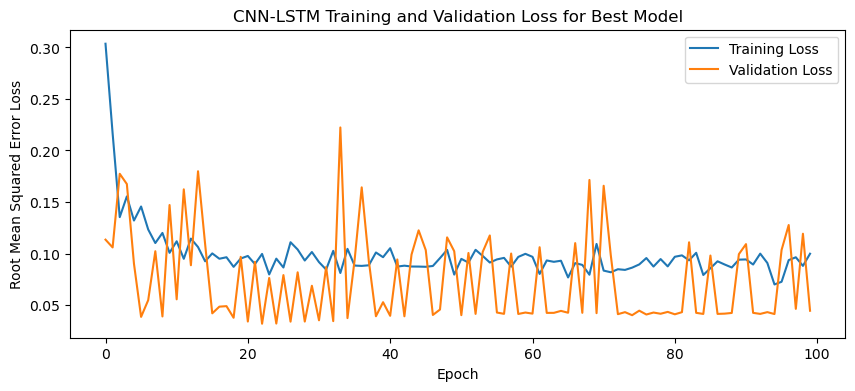

1/1 - 2s - loss: 0.1596 - 2s/epoch - 2s/step
Test Loss: 0.15955282747745514
Fold 2:
Epoch 1/100
19/19 [==============================] - 6s 126ms/step - loss: 0.3041 - val_loss: 0.2389
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1808 - val_loss: 0.0663
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1480 - val_loss: 0.3080
Epoch 4/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1620 - val_loss: 0.1687
Epoch 5/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1458 - val_loss: 0.0553
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 0.1316 - val_loss: 0.2757
Epoch 7/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1129 - val_loss: 0.1510
Epoch 8/100
19/19 [==============================] - 0s 20ms/step - loss: 0.1158 - val_loss: 0.0546
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - loss: 0.1083 - val_loss: 0.2013
Epoch 10/100
19

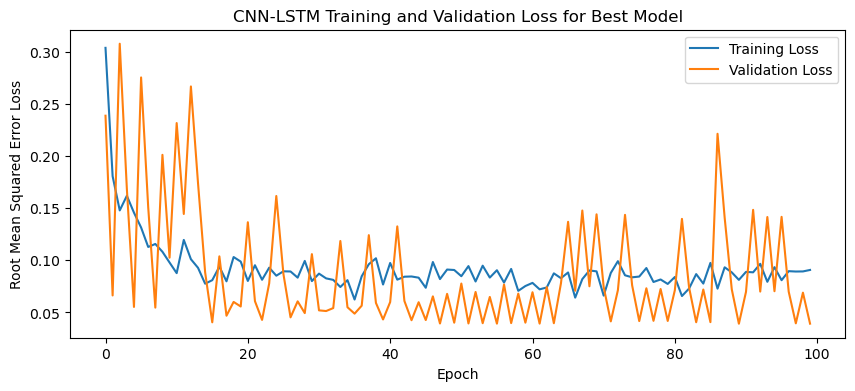

1/1 - 1s - loss: 0.1591 - 1s/epoch - 1s/step
Test Loss: 0.15906988084316254
Fold 3:
Epoch 1/100
19/19 [==============================] - 9s 122ms/step - loss: 0.2497 - val_loss: 0.3202
Epoch 2/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1886 - val_loss: 0.1017
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1449 - val_loss: 0.3749
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1386 - val_loss: 0.1377
Epoch 5/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1135 - val_loss: 0.1068
Epoch 6/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1116 - val_loss: 0.0776
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1200 - val_loss: 0.1067
Epoch 8/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1256 - val_loss: 0.1152
Epoch 9/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1100 - val_loss: 0.0732
Epoch 10/100
19

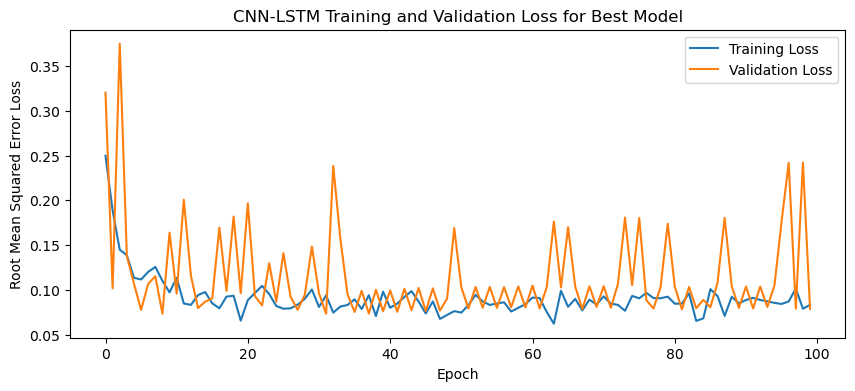

1/1 - 1s - loss: 0.1271 - 1s/epoch - 1s/step
Test Loss: 0.1271364986896515
Fold 4:
Epoch 1/100
20/20 [==============================] - 5s 77ms/step - loss: 0.2940 - val_loss: 0.0052
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.2056 - val_loss: 0.2557
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1700 - val_loss: 0.1190
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1773 - val_loss: 0.0318
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1722 - val_loss: 0.1595
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1531 - val_loss: 0.0785
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1361 - val_loss: 0.0156
Epoch 8/100
20/20 [==============================] - 0s 11ms/step - loss: 0.1641 - val_loss: 0.0401
Epoch 9/100
20/20 [==============================] - 0s 11ms/step - loss: 0.1160 - val_loss: 0.0809
Epoch 10/100
20/2

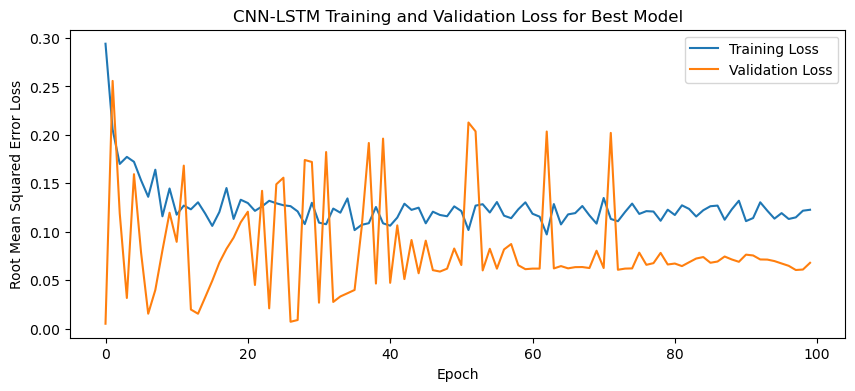

1/1 - 1s - loss: 0.1153 - 1s/epoch - 1s/step
Test Loss: 0.11531106382608414
Fold 5:
Epoch 1/100
19/19 [==============================] - 11s 118ms/step - loss: 0.3270 - val_loss: 0.1245
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.2144 - val_loss: 0.0633
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1490 - val_loss: 0.2037
Epoch 4/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1255 - val_loss: 0.1399
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1333 - val_loss: 0.0570
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1184 - val_loss: 0.2104
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1139 - val_loss: 0.2100
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1233 - val_loss: 0.0539
Epoch 9/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0980 - val_loss: 0.0976
Epoch 10/100
1

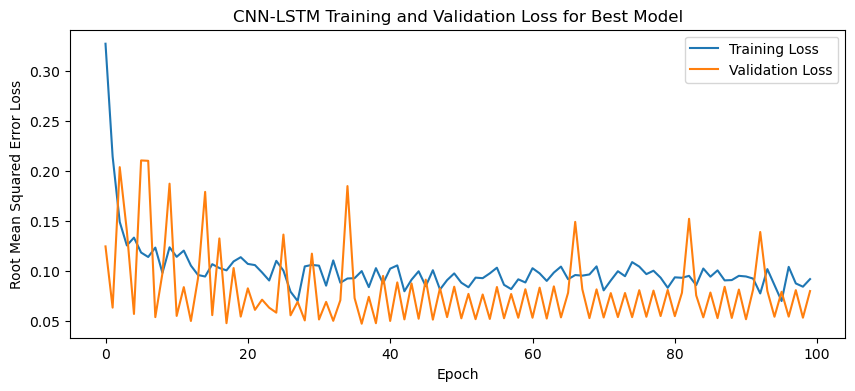

1/1 - 3s - loss: 0.0031 - 3s/epoch - 3s/step
Test Loss: 0.0031210158485919237


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

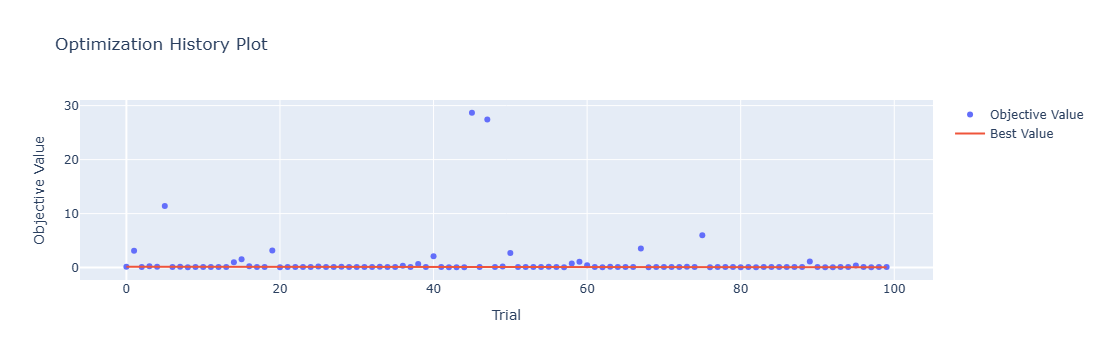

In [4]:
optuna.visualization.plot_optimization_history(study)

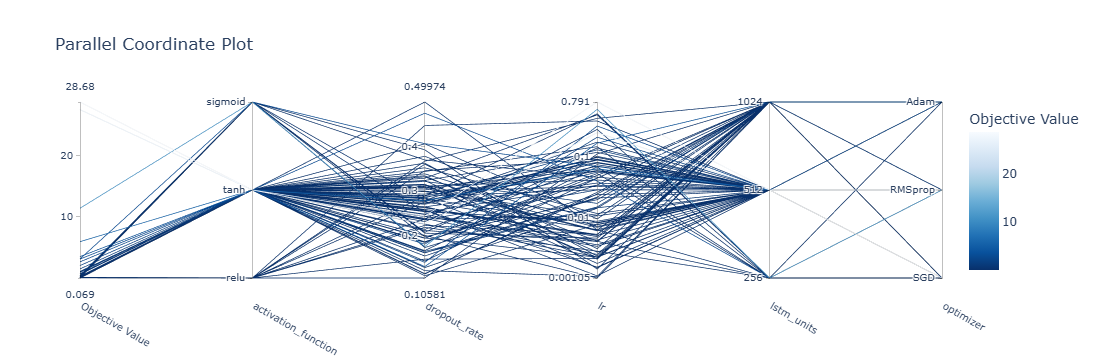

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

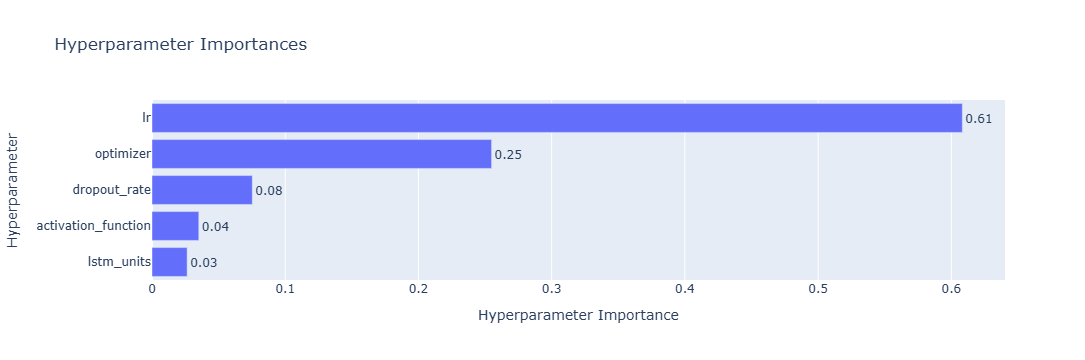

In [6]:
optuna.visualization.plot_param_importances(study)

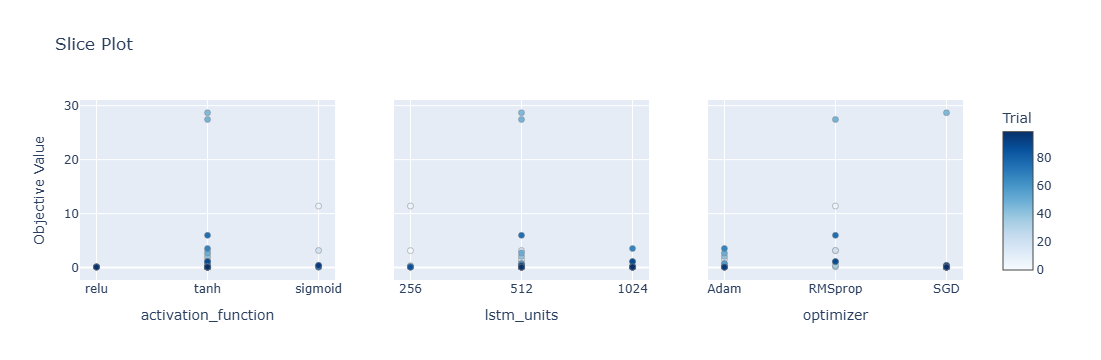

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

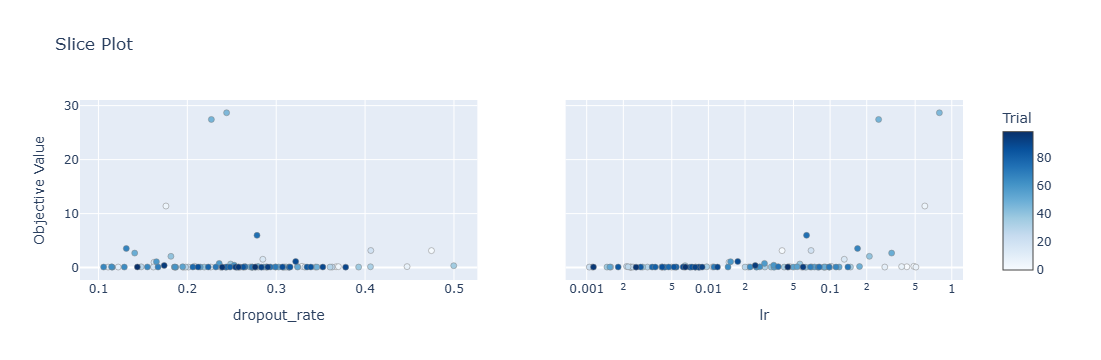

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 24s 301ms/step - loss: 0.3102 - accuracy: 0.0000e+00 - mae: 0.3102 - rmse: 0.3102 - mape: 67.6105 - pearson: nan - val_loss: 0.2300 - val_accuracy: 0.0000e+00 - val_mae: 0.2300 - val_rmse: 0.2300 - val_mape: 48.7789 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 58ms/step - loss: 0.1809 - accuracy: 0.0000e+00 - mae: 0.1809 - rmse: 0.1809 - mape: 42.6109 - pearson: nan - val_loss: 0.0346 - val_accuracy: 0.0000e+00 - val_mae: 0.0346 - val_rmse: 0.0346 - val_mape: 7.3762 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 61ms/step - loss: 0.1697 - accur

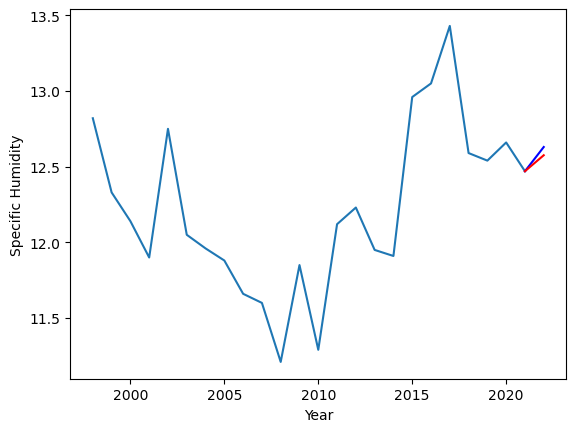

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.63		9.83		0.20


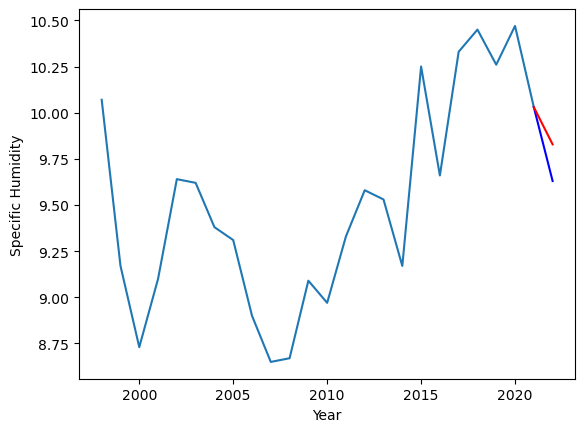

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.63  12.575589
1                1    9.63   9.828492


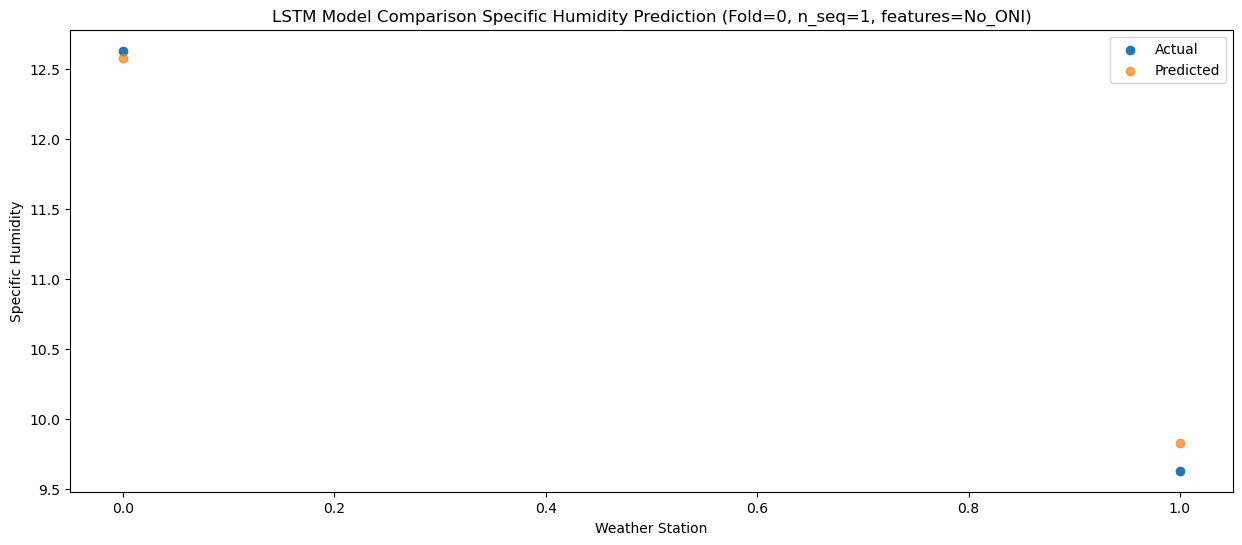

f, t:
[[12.63  9.63]]
[[12.57558938  9.8284915 ]]
Year at t+1:
t+1 SKRMSE: 0.145532
t+1 KRMSE: 0.145532
t+1 MAE: 0.126451
t+1 SKMAPE: 0.012460
t+1 R2_SCORE: 0.990587
t+1 KMAPE: 0.012460
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.130000
Metrics for this Fold:
SKRMSE: 0.145532
KRMSE: 0.145532
MAE: 0.126451
SKMAPE: 0.012460
R2_SCORE: 0.990587
KMAPE: 0.012460
PEARSON: 1.000000
AVERAGE ACTUAL: 11.130000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1020 (LSTM)            (1, 1, 512)               1546240   
                                                                 
 dropout_1020 (Dropout)      (1, 1, 512)               0         
                                                                 
 lstm_1021 (LSTM)            (1, 512)                  2099200   
                                                                 
 dropout_1021 (Dropout)      (1, 512)       

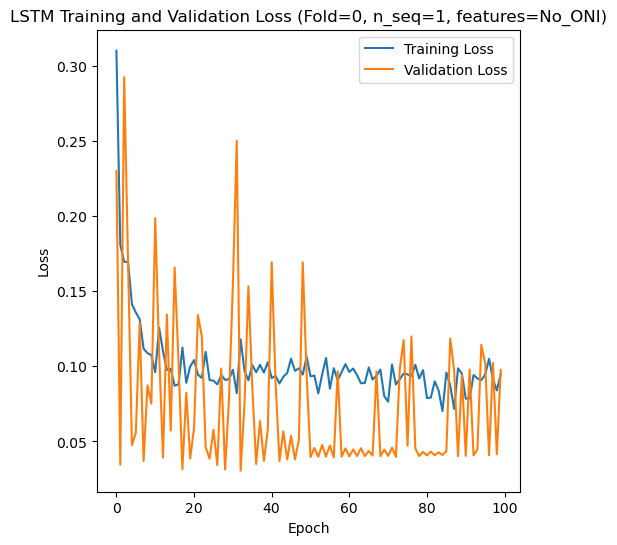

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 33s 373ms/step - loss: 0.3049 - accuracy: 0.0000e+00 - mae: 0.3049 - rmse: 0.3049 - mape: 66.7428 - pearson: nan - val_loss: 0.2002 - val_accuracy: 0.0000e+00 - val_mae: 0.2002 - val_rmse: 0.2002 - val_mape: 38.4620 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 61ms/step - loss: 0.2198 - accuracy: 0.0000e+00 - mae: 0.2198 - rmse: 0.2198 - mape: 49.7100 - pearson: nan - val_loss: 0.0694 - val_accuracy: 0.0000e+00 - val_mae: 0.0694 - val_rmse: 0.0694 - val_mape: 12.7503 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1460 - accu

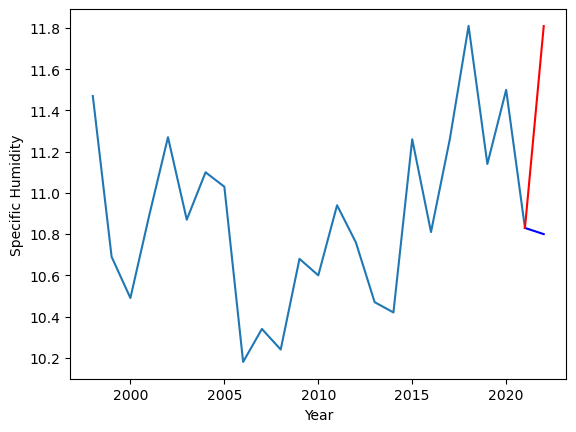

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.97		-0.10


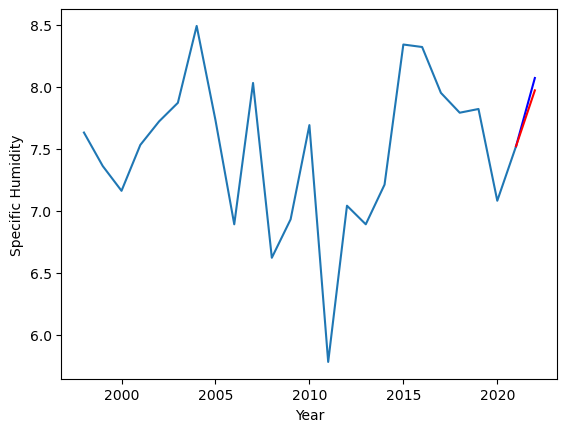

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.809148
1                1    8.07   7.970266


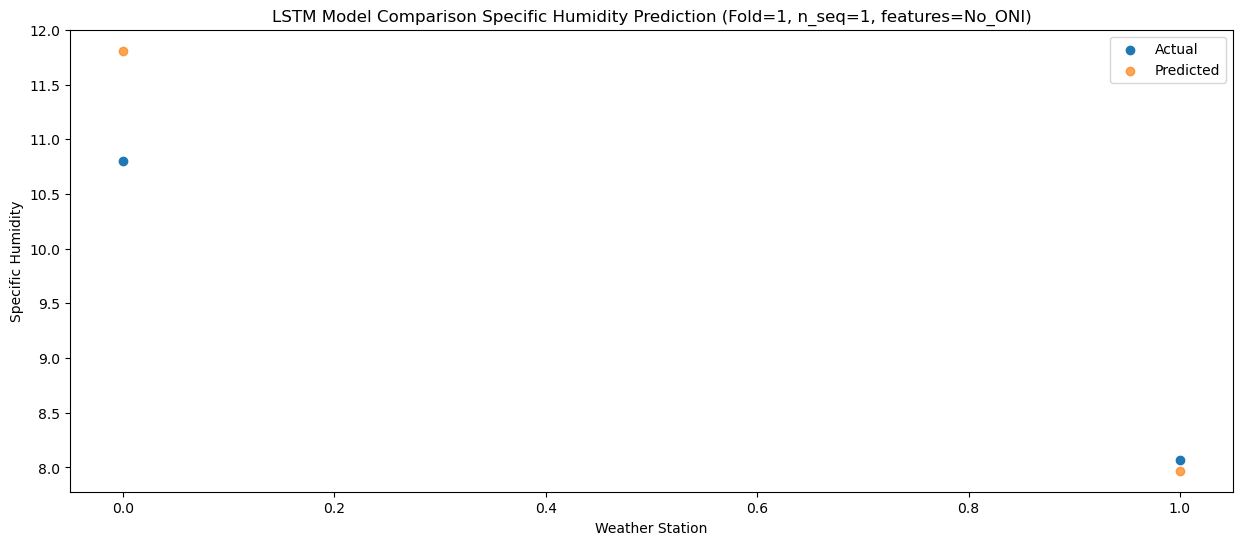

f, t:
[[10.8   8.07]]
[[11.80914825  7.97026641]]
Year at t+1:
t+1 SKRMSE: 0.717052
t+1 KRMSE: 0.717052
t+1 MAE: 0.554441
t+1 SKMAPE: 0.052899
t+1 R2_SCORE: 0.724046
t+1 KMAPE: 0.052899
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.435000
Metrics for this Fold:
SKRMSE: 0.717052
KRMSE: 0.717052
MAE: 0.554441
SKMAPE: 0.052899
R2_SCORE: 0.724046
KMAPE: 0.052899
PEARSON: 1.000000
AVERAGE ACTUAL: 9.435000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1022 (LSTM)            (1, 1, 512)               1546240   
                                                                 
 dropout_1022 (Dropout)      (1, 1, 512)               0         
                                                                 
 lstm_1023 (LSTM)            (1, 512)                  2099200   
                                                                 
 dropout_1023 (Dropout)      (1, 512)         

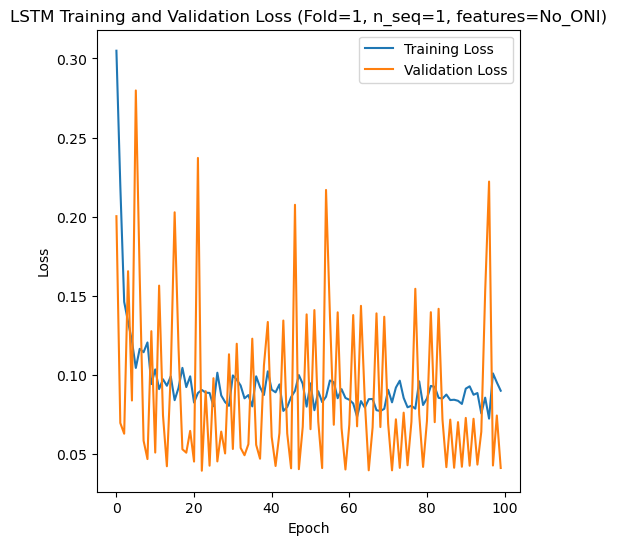

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 28s 409ms/step - loss: 0.2816 - accuracy: 0.0000e+00 - mae: 0.2816 - rmse: 0.2816 - mape: 61.1202 - pearson: nan - val_loss: 0.2697 - val_accuracy: 0.0000e+00 - val_mae: 0.2697 - val_rmse: 0.2697 - val_mape: 48.1197 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 82ms/step - loss: 0.1847 - accuracy: 0.0000e+00 - mae: 0.1847 - rmse: 0.1847 - mape: 42.1112 - pearson: nan - val_loss: 0.1065 - val_accuracy: 0.0000e+00 - val_mae: 0.1065 - val_rmse: 0.1065 - val_mape: 17.3984 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 81ms/step - loss: 0.1782 - accu

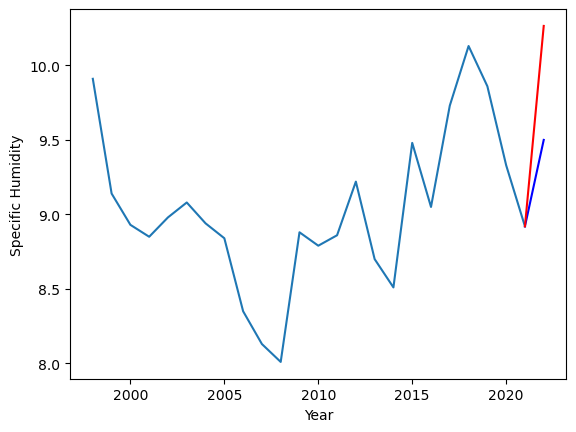

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.56		8.84		0.28


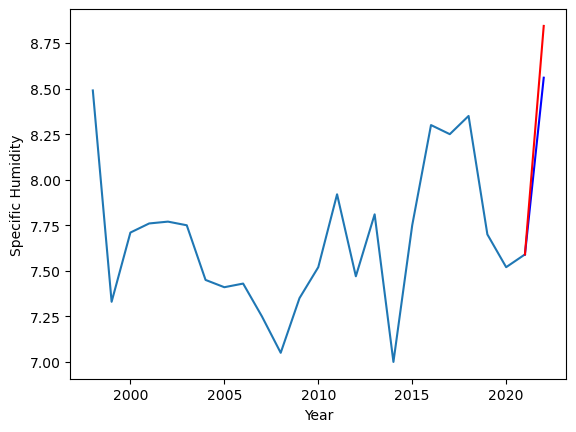

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.50  10.264921
1                1    8.56   8.844123


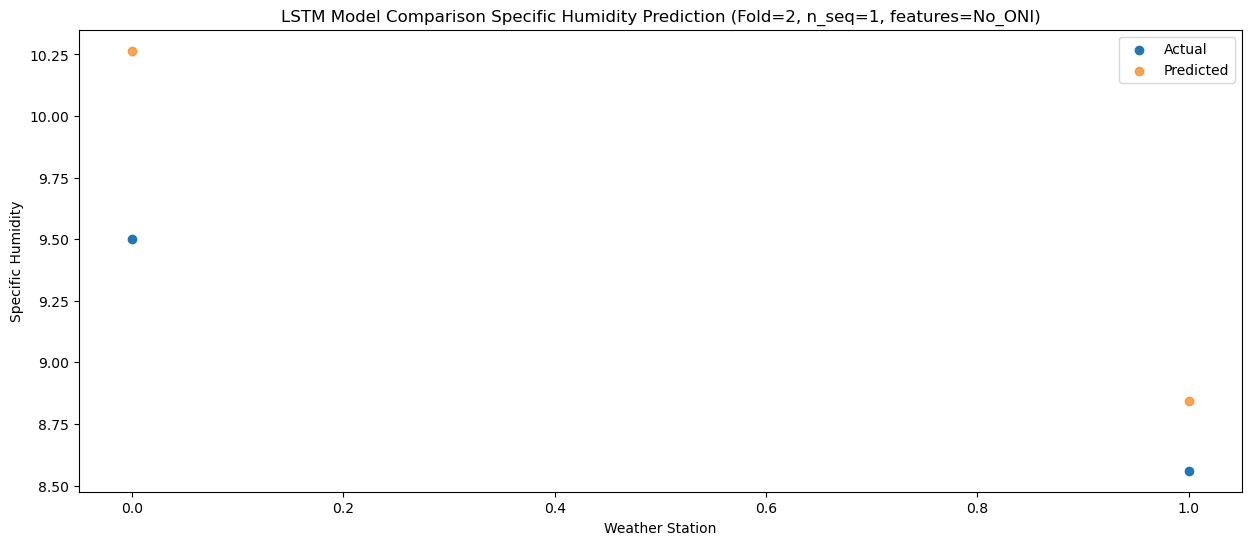

f, t:
[[9.5  8.56]]
[[10.26492128  8.84412267]]
Year at t+1:
t+1 SKRMSE: 0.576988
t+1 KRMSE: 0.576988
t+1 MAE: 0.524522
t+1 SKMAPE: 0.056855
t+1 R2_SCORE: -0.507085
t+1 KMAPE: 0.056855
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.030000
Metrics for this Fold:
SKRMSE: 0.576988
KRMSE: 0.576988
MAE: 0.524522
SKMAPE: 0.056855
R2_SCORE: -0.507085
KMAPE: 0.056855
PEARSON: 1.000000
AVERAGE ACTUAL: 9.030000
Model: "sequential_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1024 (LSTM)            (1, 1, 512)               1546240   
                                                                 
 dropout_1024 (Dropout)      (1, 1, 512)               0         
                                                                 
 lstm_1025 (LSTM)            (1, 512)                  2099200   
                                                                 
 dropout_1025 (Dropout)      (1, 512)         

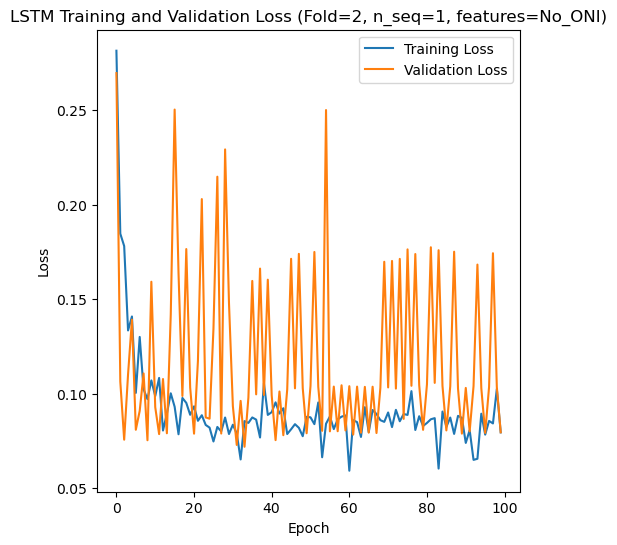

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 27s 396ms/step - loss: 0.3199 - accuracy: 0.0000e+00 - mae: 0.3199 - rmse: 0.3199 - mape: 53.1525 - pearson: nan - val_loss: 0.0134 - val_accuracy: 0.0000e+00 - val_mae: 0.0134 - val_rmse: 0.0134 - val_mape: 1.9445 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 1s 65ms/step - loss: 0.2253 - accuracy: 0.0000e+00 - mae: 0.2253 - rmse: 0.2253 - mape: 37.5786 - pearson: nan - val_loss: 0.2508 - val_accuracy: 0.0000e+00 - val_mae: 0.2508 - val_rmse: 0.2508 - val_mape: 36.0400 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 0.2239 - accuracy: 0.0000e+00 - mae: 0.2239 - rmse: 0.2239 - mape: 38.93

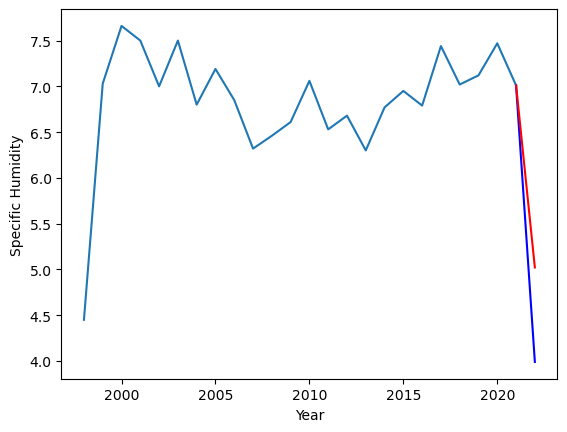

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.30		8.90		0.60


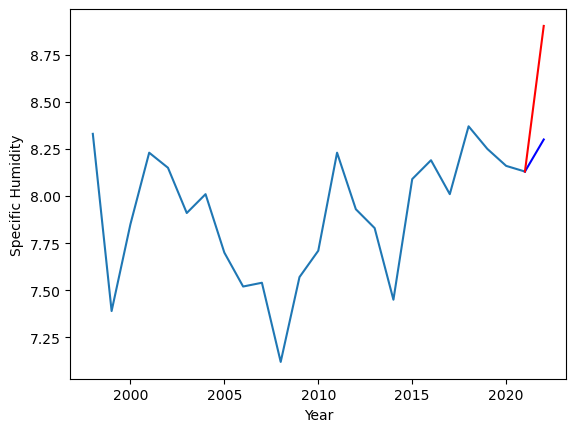

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    3.99   5.021896
1                1    8.30   8.902508


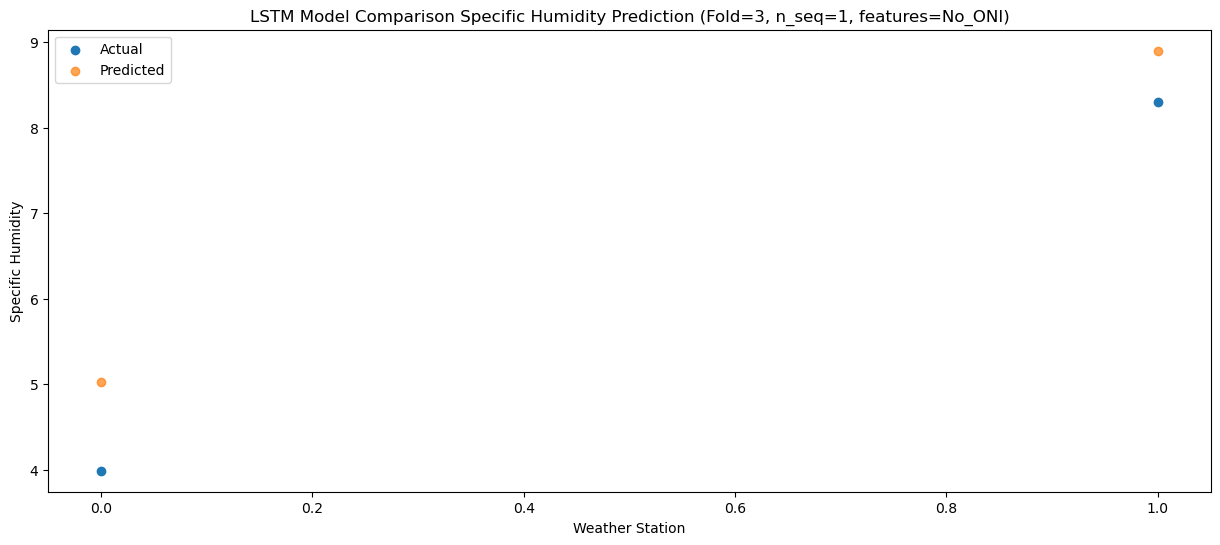

f, t:
[[3.99 8.3 ]]
[[5.02189554 8.90250762]]
Year at t+1:
t+1 SKRMSE: 0.844933
t+1 KRMSE: 0.844933
t+1 MAE: 0.817202
t+1 SKMAPE: 0.165606
t+1 R2_SCORE: 0.846273
t+1 KMAPE: 0.165606
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.145000
Metrics for this Fold:
SKRMSE: 0.844933
KRMSE: 0.844933
MAE: 0.817202
SKMAPE: 0.165606
R2_SCORE: 0.846273
KMAPE: 0.165606
PEARSON: 1.000000
AVERAGE ACTUAL: 6.145000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1026 (LSTM)            (1, 1, 512)               1546240   
                                                                 
 dropout_1026 (Dropout)      (1, 1, 512)               0         
                                                                 
 lstm_1027 (LSTM)            (1, 512)                  2099200   
                                                                 
 dropout_1027 (Dropout)      (1, 512)             

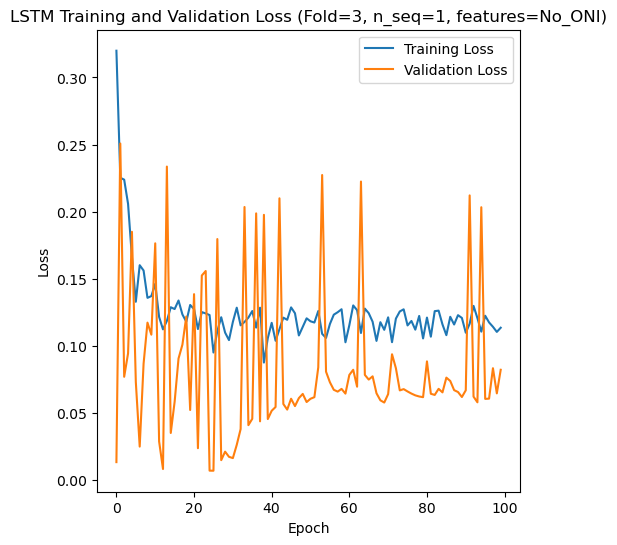

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 22s 386ms/step - loss: 0.3108 - accuracy: 0.0000e+00 - mae: 0.3108 - rmse: 0.3108 - mape: 68.0716 - pearson: nan - val_loss: 0.1030 - val_accuracy: 0.0000e+00 - val_mae: 0.1030 - val_rmse: 0.1030 - val_mape: 22.2141 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 0.2155 - accuracy: 0.0000e+00 - mae: 0.2155 - rmse: 0.2155 - mape: 48.1248 - pearson: nan - val_loss: 0.0508 - val_accuracy: 0.0000e+00 - val_mae: 0.0508 - val_rmse: 0.0508 - val_mape: 13.6769 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1437 - accur

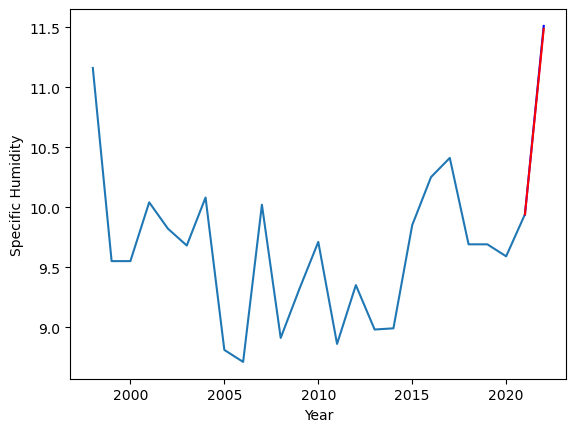

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.66		8.66		-0.00


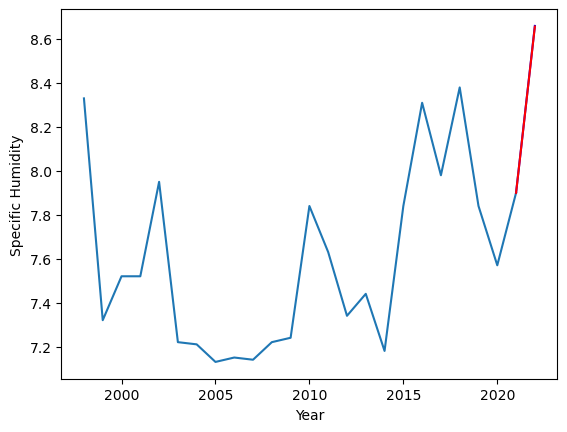

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.51  11.485435
1                1    8.66   8.656763


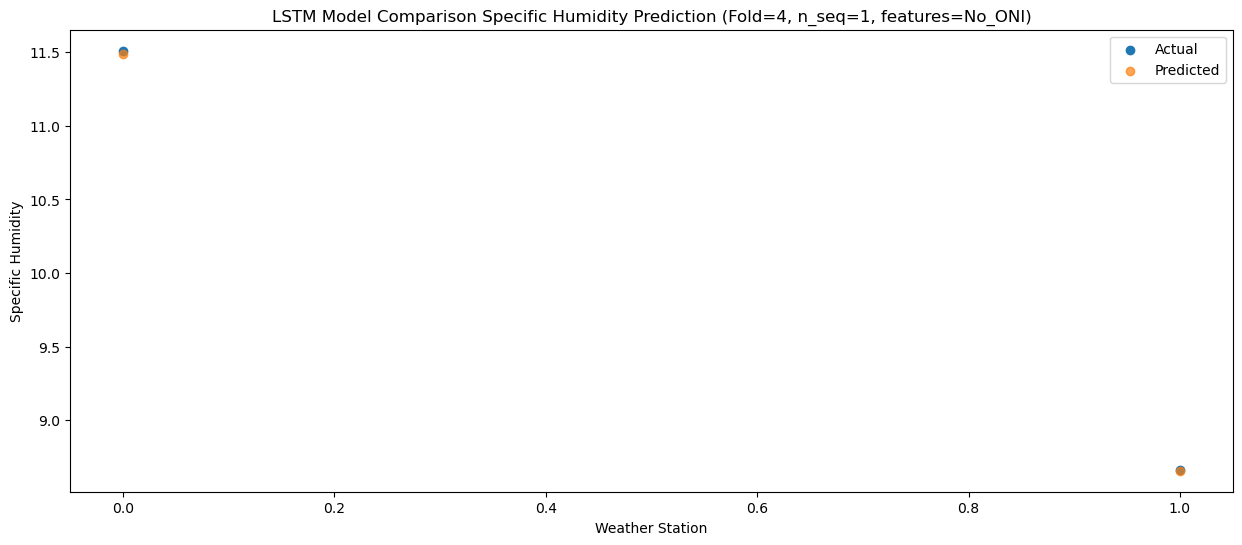

f, t:
[[11.51  8.66]]
[[11.48543534  8.65676333]]
Year at t+1:
t+1 SKRMSE: 0.017520
t+1 KRMSE: 0.017520
t+1 MAE: 0.013901
t+1 SKMAPE: 0.001254
t+1 R2_SCORE: 0.999849
t+1 KMAPE: 0.001254
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 10.085000
Metrics for this Fold:
SKRMSE: 0.017520
KRMSE: 0.017520
MAE: 0.013901
SKMAPE: 0.001254
R2_SCORE: 0.999849
KMAPE: 0.001254
PEARSON: 1.000000
AVERAGE ACTUAL: 10.085000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1028 (LSTM)            (1, 1, 512)               1546240   
                                                                 
 dropout_1028 (Dropout)      (1, 1, 512)               0         
                                                                 
 lstm_1029 (LSTM)            (1, 512)                  2099200   
                                                                 
 dropout_1029 (Dropout)      (1, 512)       

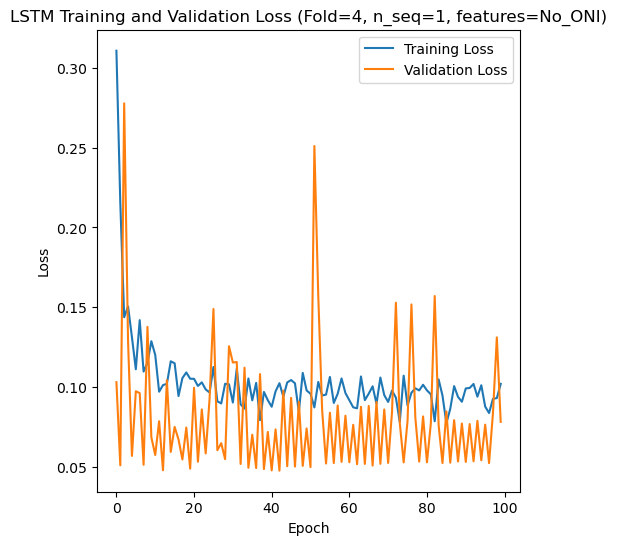

[[0.1455324560512259], [0.7170519460285826], [0.5769879796848488], [0.8449330852098569], [0.017519967487068303]]
[[array(0.14553246)], [array(0.71705195)], [array(0.57698798)], [array(0.84493309)], [array(0.01751997)]]
[[0.12645106017589658], [0.5544409233331682], [0.5245219749212264], [0.8172015798091885], [0.013900663852691508]]
[[0.012459916032654506], [0.05289910742091065], [0.05685496507037524], [0.1656058577655806], [0.0012539753665444771]]
[[0.9905868018825325], [0.7240464821460761], [-0.5070852363096603], [0.8462730242661813], [0.9998488400070186]]
[[array(0.01245992)], [array(0.05289911)], [array(0.05685497)], [array(0.16560586)], [array(0.00125398)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[12.63  9.63 10.8   8.07  9.5   8.56  3.99  8.3  11.51  8.66]
[12.57558938  9.8284915  11.80914825  7.97026641 10.26492128  8.84412267
  5.02189554  8.90250762 11.48543534  8.65676333]
Accuracy Results:
RMSE for each fold:
[[0.1455324560512259], [0.7170519460285826

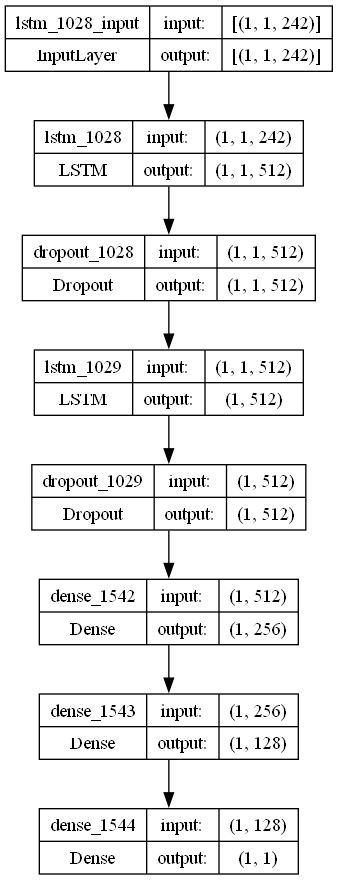

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.06318439670364742
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.30801763552048006

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)